In [1]:
import numpy as np
from util import *
from abc import ABC, abstractmethod
from calculate_alpha import *
import scipy
from sklearn.linear_model import Lasso, LinearRegression
import statsmodels.api as sm
from typing import Callable
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings("ignore")

In [2]:
class ContextualBandit(ABC):
    @abstractmethod
    def choose(self, x): pass
    
    @abstractmethod
    def update(self, x, r): pass

In [3]:
def orthogonal_complement_basis(X):
    d, K = X.shape
    
    # Perform Singular Value Decomposition
    _, _, Vt = np.linalg.svd(X)

    # Find the rank of X to determine the number of non-zero singular values
    rank = np.linalg.matrix_rank(X)
    # print(f"rank : {rank}")

    # The basis for the null space (orthogonal complement of the row space)
    # is given by the columns of V corresponding to zero singular values
    if rank < K:
        null_space_basis = Vt[rank:].T
    else:
        null_space_basis = Vt.T

    return null_space_basis

In [4]:
class RoLFLasso(ContextualBandit):
    def __init__(self, d:int, arms:int, p:float, delta:float, sigma:float, random_state:int, explore:bool=False, init_explore:int=0):
        self.t = 0
        self.d = d
        self.K = arms
        self.mu_hat = np.zeros(self.K)
        self.impute_prev = np.zeros(self.K)
        self.main_prev = np.zeros(self.K)
        self.sigma = sigma          # variance of noise
        self.p = p                  # hyperparameter for action sampling
        self.delta = delta          # confidence parameter
        self.action_history = []    # history of chosen actions up to the current round
        self.reward_history = []    # history of observed rewards up to the current round
        self.matching = dict()      # history of rounds that the pseudo action and the chosen action matched
        self.random_state = random_state
        self.explore = explore
        self.init_explore = init_explore

    def choose(self, x: np.ndarray):
        # x : (K, d) augmented feature matrix where each row denotes the augmented features
        self.t += 1

        ## compute the \hat{a}_t
        if self.explore:
            if self.t > self.init_explore:
                decision_rule = x @ self.mu_hat
                # print(f"Decision rule : {decision_rule}")
                a_hat = np.argmax(decision_rule)
            else:
                a_hat = np.random.choice(np.arange(self.K))
        else:
            decision_rule = x @ self.mu_hat
            # print(f"Decision rule : {decision_rule}")
            a_hat = np.argmax(decision_rule)

        self.a_hat = a_hat

        ## sampling actions
        pseudo_action = -1
        chosen_action = -2
        count = 0
        max_iter = int(np.log((self.t + 1) ** 2 / self.delta) / np.log(1 / self.p))
        pseudo_dist = np.array([(1 - self.p) / (self.K - 1)] * self.K, dtype=float)
        pseudo_dist[a_hat] = self.p
        chosen_dist = np.array([(1 / np.sqrt(self.t)) / (self.K - 1)] * self.K, dtype=float)
        chosen_dist[a_hat] = 1 - (1 / np.sqrt(self.t))

        np.random.seed(self.random_state + self.t)
        while (pseudo_action != chosen_action) and (count <= max_iter):
            ## Sample the pseudo action
            pseudo_action = np.random.choice([i for i in range(self.K)], size=1, replace=False, p=pseudo_dist).item()
            ## Sample the chosen action
            chosen_action = np.random.choice([i for i in range(self.K)], size=1, replace=False, p=chosen_dist).item()
            count += 1

        self.action_history.append(chosen_action) # add to the history
        self.pseudo_action = pseudo_action
        self.chosen_action = chosen_action
        return chosen_action

    def update(self, x: np.ndarray, r: float):
        # x : (K, d) augmented feature matrix
        # r : reward of the chosen_action
        self.reward_history.append(r)

        # lam_impute = 2 * self.p * self.sigma * np.sqrt(2 * self.t * np.log(2 * self.K * (self.t ** 2) / self.delta))
        # lam_main = (1 + 2 / self.p) * self.sigma * np.sqrt(2 * self.t * np.log(2 * self.K * (self.t ** 2) / self.delta))

        # lam_impute = self.p * np.sqrt(np.log(self.t))
        # lam_main = self.p * np.sqrt(np.log(self.t))

        lam_impute = self.p
        lam_main = self.p

        if self.pseudo_action == self.chosen_action:
            ## compute the imputation estimator
            data_impute = x[self.action_history, :]  # (t, d) matrix
            target_impute = np.array(self.reward_history)
            mu_impute = scipy.optimize.minimize(self.__imputation_loss, self.impute_prev, args=(data_impute, target_impute, lam_impute),
                                                method="SLSQP", options={'disp': False, "ftol":1e-6, "maxiter":10000}).x

            ## compute and update the pseudo rewards
            if self.matching:
                for key in self.matching:
                    matched, data, _, chosen, reward = self.matching[key]
                    if matched:
                        new_pseudo_rewards = data @ mu_impute
                        new_pseudo_rewards[chosen] += (1 / self.p) * (reward - (data[chosen, :] @ mu_impute))
                        # overwrite the value
                        self.matching[key] = (matched, data, new_pseudo_rewards, chosen, reward)

            ## compute the pseudo rewards for the current data
            pseudo_rewards = x @ mu_impute
            pseudo_rewards[self.chosen_action] += (1 / self.p) * (r - (x[self.chosen_action, :] @ mu_impute))
            self.matching[self.t] = ((self.pseudo_action == self.chosen_action), x, pseudo_rewards, self.chosen_action, r)

            ## compute the main estimator
            mu_main = scipy.optimize.minimize(self.__main_loss, self.main_prev, args=(lam_main, self.matching),
                                              method="SLSQP", options={'disp': False, "ftol":1e-6, "maxiter":10000}).x

            ## update the mu_hat
            self.mu_hat = mu_main
        else:
            self.matching[self.t] = ((self.pseudo_action == self.chosen_action), None, None, None, None)

    def __imputation_loss(self, beta:np.ndarray, X:np.ndarray, y:np.ndarray, lam:float):
        # print(f"X : {X.shape}, beta : {beta.shape}")
        residuals = (y - (X @ beta)) ** 2
        loss = np.sum(residuals, axis=0)
        l1_norm = vector_norm(beta, type="l1")
        return loss + (lam * l1_norm)

    def __main_loss(self, beta:np.ndarray, lam:float, matching_history:dict):
        ## matching_history : dict[t] = (bool, X, y) - bool denotes whether the matching event occurred or not
        loss = 0
        for key in matching_history:
            matched, X, pseudo_rewards, _, _ = matching_history[key]
            if matched:
                residuals = (pseudo_rewards - (X @ beta)) ** 2
                interim_loss = np.sum(residuals, axis=0)
            else:
                interim_loss = 0
            loss += interim_loss
        l1_norm = vector_norm(beta, type="l1")
        return loss + (lam * l1_norm)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

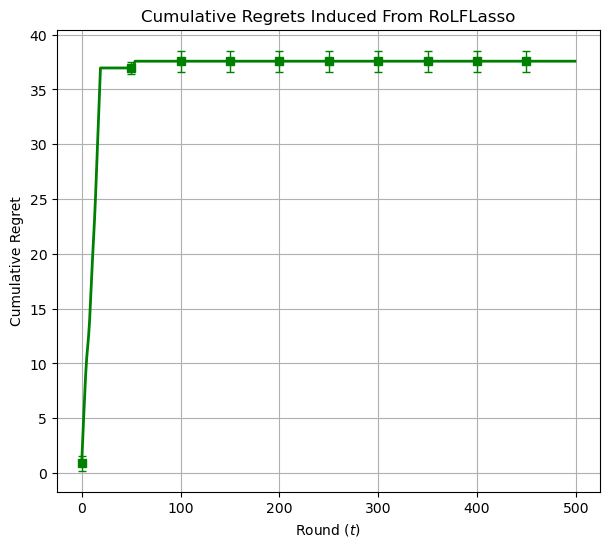

In [22]:
SEED = 617
## Environment
K = 20
d = 15
T = 500
s0 = 5
delta = 0.001
p = 0.6
explore = True
init_explore = K
action_space = 10000
# rho_sq = 0.5

sigma = 1
rho_sq = 0.7
V = (sigma - rho_sq) * np.eye(K) + rho_sq * np.ones((K, K))

np.random.seed(SEED)
beta = np.zeros(d)
inds = np.random.choice(range(d), s0, replace=False)
beta[inds] = np.random.uniform(0., 1., s0)

X = np.random.multivariate_normal(mean=np.zeros(K), cov=V, size=d) # (d, K)
basis = orthogonal_complement_basis(X)
# print(f"X.shape:{X.shape}, basis.shape:{basis.shape}")
x_aug = np.hstack((X.T, basis))
bounding(type="feature", v=x_aug, bound=1., method="clipping", norm_type="lsup")
exp_rewards = X.T @ beta
if d < K:
    data = x_aug
else:
    data = basis

# print(f"X : {X.shape}, data : {data.shape}")
trials = 3
regret_container = np.zeros(trials, dtype=object)
for trial in range(trials):
    regrets = np.zeros(T, dtype=float)
    agent = RoLFLasso(d=d, arms=K, p=p, delta=delta, sigma=0.1, 
                      random_state=SEED+trial, explore=explore, init_explore=init_explore)
    for t in tqdm(range(T)):
        random_state_ = SEED + trial + t + 1
        optimal_reward = np.amax(exp_rewards)
        noise = subgaussian_noise(distribution="gaussian", size=1, std=0.1, random_state=random_state_)
        chosen_action = agent.choose(data)
        chosen_reward = exp_rewards[chosen_action] + noise
        regrets[t] = optimal_reward - exp_rewards[chosen_action]
        agent.update(data, chosen_reward)

    regret_container[trial] = np.cumsum(regrets)

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

rounds = np.arange(T)
mean = np.mean(regret_container, axis=0)
std = np.std(regret_container, axis=0, ddof=1)
period = T // 10

# 마커와 에러 바가 있는 라인을 주기적으로 표시
ax.errorbar(rounds[::period], mean[::period], yerr=std[::period], fmt='s', color="green", capsize=3, elinewidth=1)

# 주기적인 마커 없이 전체 라인을 표시
ax.plot(rounds, mean, color="green", linewidth=2)

ax.set_title(f'Cumulative Regrets Induced From {agent.__class__.__name__}')
ax.set_xlabel(r"Round ($t$)")
ax.set_ylabel("Cumulative Regret")
ax.grid(True)
plt.show()

In [11]:
class DRLassoBandit(ContextualBandit):
    def __init__(self, d:int, arms:int, lam1:float, lam2:float, zT:float, tr:bool):
        ## learning params
        self.d = d
        self.arms = arms
        self.lam1 = lam1
        self.lam2 = lam2
        self.tr = tr
        self.zT = zT

        ## initialization
        self.beta_prev = np.zeros(self.d)
        self.beta_hat = np.zeros(self.d)
        self.pi_t = 0
        self.x = []     # containing context history
        self.r = []     # containing reward history
        self.t = 0      # learning round

    def choose(self, x):
        ## x : (K, d) array - all contexts observed at t
        self.t += 1
        if self.t <= self.zT:
            # forced sampling
            self.action = np.random.choice(self.arms, replace=False)
            self.pi_t = 1 / self.arms
        else:
            # UCB
            expected_reward = x @ self.beta_hat     # (K, ) array
            lam1 = self.lam1 * np.sqrt((np.log(self.t) + np.log(self.d)) / self.t)
            lam1 = np.minimum(1, np.maximum(0, lam1))
            self.mt = np.random.choice([0, 1], p=[1-lam1, lam1])
            if self.mt == 1:
                self.action = np.random.choice(self.arms)
            else:
                self.action = np.argmax(expected_reward)

            self.pi_t = (lam1 / self.arms) + ((1-lam1) * (self.action == np.argmax(expected_reward)))

        bar_x = np.mean(x, axis=0)
        self.x.append(bar_x)
        self.rhat = x @ self.beta_hat

        return self.action

    def update(self, x, r):
        ## x : (d, ) array - context of the chosen action
        ## r : float - reward
        r_hat = np.mean(self.rhat) + ((r - self.rhat[self.action]) / (self.arms * self.pi_t))
        if self.tr:
            r_hat = np.minimum(3., np.maximum(-3., r_hat))
        self.r.append(r_hat)

        lam2 = self.lam2 * np.sqrt((np.log(self.t) + np.log(self.d)) / self.t)
        data, target = np.vstack(self.x), np.array(self.r)
        self.beta_hat = scipy.optimize.minimize(self.__lasso_loss, self.beta_prev, args=(data, target, lam2),
                                                method="SLSQP", options={'disp': False, "ftol":1e-6, "maxiter":30000}).x

    def __lasso_loss(self, beta:np.ndarray, X:np.ndarray, y:np.ndarray, lam:float):
        loss = np.sum((y - X @ beta) ** 2, axis=0)
        l1norm = np.sum(np.abs(beta))
        return loss + (lam * l1norm)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

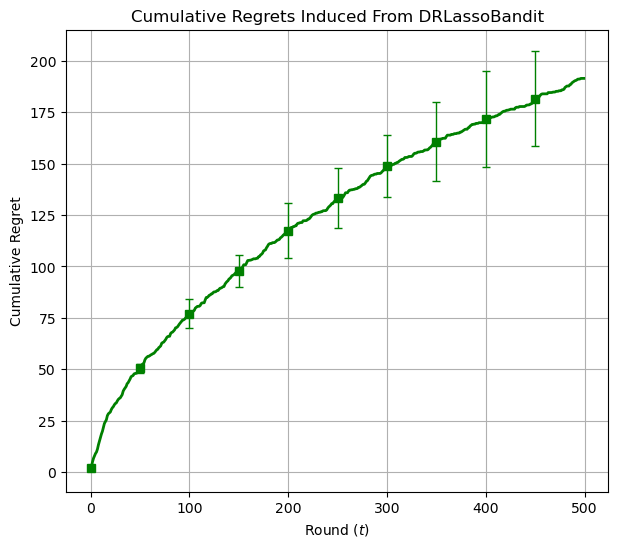

In [23]:
SEED = 617
## Environment
K = 20
d = 15
T = 500
phi = 1
s0 = 5
delta = 0.001
zT = K
lam1, lam2 = 1, 0.5

R = 0.05
sigma = 1
rho_sq = 0.7
V = (sigma - rho_sq) * np.eye(K) + rho_sq * np.ones((K, K))

trials = 5

np.random.seed(SEED)
beta = np.zeros(d)
inds = np.random.choice(range(d), s0, replace=False)
beta[inds] = np.random.uniform(0., 1., s0)
# beta = np.random.uniform(0, 1, d)

trial_regret = np.zeros(trials, dtype=object)
for trial in range(trials):
    regrets = np.zeros(T, dtype=float)
    agent = DRLassoBandit(d=d, arms=K, lam1=lam1, lam2=lam2, zT=zT, tr=True)
    for t in tqdm(range(T)):
        random_state_ = SEED + (103*trial) + (t+1)
        np.random.seed(random_state_)
        X = np.random.multivariate_normal(mean=np.zeros(K), cov=V, size=d).T    # (K, d)

        ## copmute the reward and optimal reward
        expected_reward = X @ beta
        optimal_reward = np.amax(expected_reward)

        ## action selection
        noise = R * np.random.randn()
        chosen_action = agent.choose(x=X)
        chosen_reward = expected_reward[chosen_action] + noise

        ## copmute regret
        regret = optimal_reward - expected_reward[chosen_action]
        regrets[t] = regret

        ## update the agent
        agent.update(x=X[chosen_action], r=chosen_reward)

    trial_regret[trial] = np.cumsum(regrets)

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

rounds = np.arange(T)
mean = np.mean(trial_regret, axis=0)
std = np.std(trial_regret, axis=0, ddof=1)
period = T // 10

# 마커와 에러 바가 있는 라인을 주기적으로 표시
ax.errorbar(rounds[::period], mean[::period], yerr=std[::period], fmt='s', color="green", capsize=3, elinewidth=1)

# 주기적인 마커 없이 전체 라인을 표시
ax.plot(rounds, mean, color="green", linewidth=2)

ax.set_title(f'Cumulative Regrets Induced From {agent.__class__.__name__}')
ax.set_xlabel(r"Round ($t$)")
ax.set_ylabel("Cumulative Regret")
ax.grid(True)
plt.show()